In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

Initialize overparameterized network

In [8]:
# Define the MLP with a single hidden layer without bias
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size, bias=False)
        self.fc2 = nn.Linear(hidden_size, output_size, bias=False)

    def forward(self, x):
        x = x.view(-1, 28*28)  # Flatten the input
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the MLP with a hidden layer of size 128
model = MLP(28*28, 128, 10)

# Save a copy of the initial weights to list of numpy arrays
initial_weights = [model.fc1.weight.detach().cpu().clone().numpy(), model.fc2.weight.detach().cpu().clone().numpy()]

Load MNIST Data

In [9]:
train_dataset = datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

Evaluate Network

In [10]:
import torch
import itertools

def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    loss = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            batch_loss = torch.nn.CrossEntropyLoss()(outputs, labels)
            loss += batch_loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_accuracy = 100 * correct / total
    test_loss = loss / total
    return test_accuracy, test_loss

num_batches = 10
accuracy, test_loss = evaluate(model, itertools.islice(test_loader, num_batches))
print(f"Test Accuracy: {accuracy:.2f}%, Test Loss: {test_loss:.4f}")



Test Accuracy: 14.22%, Test Loss: 0.0360


Function to initialize mask population

In [11]:
def initialize_masks(weights,subnet_size,num_subnets=1):

    # Flatten and concatenate all weight matrices
    concatenated_weights = np.concatenate([w.flatten() for w in weights])

    # Determine number of weights to zero out
    num_zero_out = int(subnet_size * len(concatenated_weights))
    mask_pop = []

    for i in range(num_subnets):

        # Randomly choose indices to zero out
        zero_indices = np.random.choice(len(concatenated_weights), num_zero_out, replace=False)

        # Create a mask for concatenated weights
        concatenated_mask = np.ones_like(concatenated_weights)
        concatenated_mask[zero_indices] = 0

        # Split the concatenated mask back into individual masks
        split_indices = np.cumsum([len(w.flatten()) for w in weights[:-1]])
        masks = np.split(concatenated_mask, split_indices)

        # Reshape each mask to match the corresponding weight matrix
        for j, w in enumerate(weights):
            masks[j] = masks[j].reshape(w.shape)

        #add to population
        mask_pop.append(masks)

    return mask_pop

In [12]:
import itertools

def evaluate_masked_model_loss_and_accuracy(model, mask, initial_weights, test_loader, criterion, num_batches=5):
    # Apply the mask to the initial weights
    masked_weights = [w * m for w, m in zip(initial_weights, mask)]

    # Set the masked weights to the model
    with torch.no_grad():
        for param, weight in zip(model.parameters(), masked_weights):
            param.data = torch.tensor(weight).float()

    # Evaluate the model's performance using a subset of the test data
    accuracy, loss = evaluate(model, itertools.islice(test_loader, num_batches))

    return accuracy, loss

def sort_and_evaluate_masks(mask_pop, model, initial_weights, test_loader, criterion, print_results=False):
    performance = []

    for i, mask in enumerate(mask_pop):
        accuracy, avg_test_loss = evaluate_masked_model_loss_and_accuracy(model, mask, initial_weights, test_loader, criterion)
        performance.append((mask, accuracy, avg_test_loss))

    # Sort by accuracy (descending)
    sorted_performance = sorted(performance, key=lambda x: x[1], reverse=True)

    # Print sorted results
    if print_results:
        for i, (mask, accuracy, avg_test_loss) in enumerate(sorted_performance):
            print(f"Ranked {i+1}, Mask {i}: Test Accuracy = {accuracy:.2f}%, Test Loss = {avg_test_loss:.4f}")

    # Return sorted mask population
    sorted_mask_pop = [mask for mask, _, _ in sorted_performance]
    return sorted_mask_pop


Create Mask Population

In [13]:
# Create masks
subnet_size = 0.1
mask_pop = initialize_masks(initial_weights, subnet_size, num_subnets=100)

# Criterion for loss computation
criterion = nn.CrossEntropyLoss()

# Sort and evaluate masks
mask_pop = sort_and_evaluate_masks(mask_pop, model, initial_weights, test_loader, criterion, print_results = True)


Ranked 1, Mask 0: Test Accuracy = 17.50%, Test Loss = 0.0359
Ranked 2, Mask 1: Test Accuracy = 17.19%, Test Loss = 0.0358
Ranked 3, Mask 2: Test Accuracy = 16.88%, Test Loss = 0.0359
Ranked 4, Mask 3: Test Accuracy = 16.25%, Test Loss = 0.0360
Ranked 5, Mask 4: Test Accuracy = 16.25%, Test Loss = 0.0360
Ranked 6, Mask 5: Test Accuracy = 15.62%, Test Loss = 0.0360
Ranked 7, Mask 6: Test Accuracy = 15.62%, Test Loss = 0.0359
Ranked 8, Mask 7: Test Accuracy = 15.31%, Test Loss = 0.0360
Ranked 9, Mask 8: Test Accuracy = 15.31%, Test Loss = 0.0360
Ranked 10, Mask 9: Test Accuracy = 15.00%, Test Loss = 0.0360
Ranked 11, Mask 10: Test Accuracy = 15.00%, Test Loss = 0.0359
Ranked 12, Mask 11: Test Accuracy = 15.00%, Test Loss = 0.0360
Ranked 13, Mask 12: Test Accuracy = 15.00%, Test Loss = 0.0359
Ranked 14, Mask 13: Test Accuracy = 14.69%, Test Loss = 0.0360
Ranked 15, Mask 14: Test Accuracy = 14.69%, Test Loss = 0.0359
Ranked 16, Mask 15: Test Accuracy = 14.69%, Test Loss = 0.0359
Ranked 17, 

Evolution

In [17]:
import random

def mutate_mask(mask, m):
    # Convert mask to a 1D NumPy array
    flat_mask = np.concatenate([w.flatten() for w in mask])

    # Get the indices of ones and zeros
    one_indices = np.where(flat_mask == 1)[0]
    zero_indices = np.where(flat_mask == 0)[0]

    # Randomly select m ones and zeros to switch
    selected_ones = np.random.choice(one_indices, m, replace=False)
    selected_zeros = np.random.choice(zero_indices, m, replace=False)

    # Switch selected ones and zeros
    flat_mask[selected_ones] = 0
    flat_mask[selected_zeros] = 1

    # Reshape the flat mask back to the original shape
    start = 0
    mutated_mask = []
    for w in mask:
        end = start + w.size
        reshaped_mask = flat_mask[start:end].reshape(w.shape)
        mutated_mask.append(reshaped_mask)
        start = end

    return mutated_mask

def evolutionary_optimization(model, initial_weights, test_loader, criterion, num_epochs=100, num_subnets=10, subnet_size=0.1, n=5, m=5):
    mask_pop = initialize_masks(initial_weights, subnet_size, num_subnets=num_subnets)
    top_accuracies = []

    for epoch in range(num_epochs):
        mask_pop = sort_and_evaluate_masks(mask_pop, model, initial_weights, test_loader, criterion)
        top_mask_accuracy, _ = evaluate_masked_model_loss_and_accuracy(model, mask_pop[0], initial_weights, test_loader, criterion)
        top_accuracies.append(top_mask_accuracy)
        if epoch % 50 == 0:
            print(f"Epoch {epoch + 1}/{num_epochs}: Highest Accuracy = {top_mask_accuracy:.2f}%")

        top_n_masks = mask_pop[:n]
        mask_pop = mask_pop[:-n]

        for mask in top_n_masks:
            mutated_mask = mutate_mask(mask, m)
            mask_pop.append(mutated_mask)

        assert len(mask_pop) == num_subnets

    return top_accuracies

def random_search(model, initial_weights, test_loader, criterion, num_epochs=10, num_subnets=10, subnet_size=0.1):
    top_accuracies = []
    real_top_mask_accuracy = 0
    top_mask = None

    for epoch in range(num_epochs):
        mask_pop = initialize_masks(initial_weights, subnet_size, num_subnets=num_subnets)
        mask_pop = sort_and_evaluate_masks(mask_pop, model, initial_weights, test_loader, criterion)
        top_mask_accuracy, _ = evaluate_masked_model_loss_and_accuracy(model, mask_pop[0], initial_weights, test_loader, criterion)
        top_accuracies.append(real_top_mask_accuracy)

        if real_top_mask_accuracy < top_mask_accuracy:
            real_top_mask_accuracy = top_mask_accuracy
            top_mask = mask_pop[0]

        print(f"Epoch {epoch + 1}/{num_epochs}: Highest Accuracy = {real_top_mask_accuracy:.2f}%")

    return top_accuracies

In [15]:
import matplotlib.pyplot as plt

def plot_accuracies(evolutionary_accuracies, random_accuracies):
    epochs = list(range(1, len(evolutionary_accuracies) + 1))

    plt.plot(epochs, evolutionary_accuracies, label='Evolutionary Optimization')
    plt.plot(epochs, random_accuracies, label='Random Search')

    plt.xlabel('Generations')
    plt.ylabel('Top Accuracy')
    plt.title('Comparison of Evolutionary Optimization and Random Search')
    plt.legend()
    plt.grid(True)
    plt.show()



# Initialize the evolutionary optimization parameters
criterion = nn.CrossEntropyLoss()
num_epochs = 1000
num_subnets = 10
subnet_size = 0.1
n = 5
m = 1000

In [18]:
# Call the evolutionary optimization function
print("Evolutionary Optimization")
evolutionary_accuracies = evolutionary_optimization(model,initial_weights,test_loader,criterion,num_epochs,num_subnets,subnet_size,n,m)

# Call the random method to compare
print("Random Search")
random_accuracies = random_search(model,initial_weights,test_loader,criterion,num_epochs,num_subnets,subnet_size)

Evolutionary Optimization
Epoch 1/1000: Highest Accuracy = 16.56%
Epoch 51/1000: Highest Accuracy = 22.50%
Epoch 101/1000: Highest Accuracy = 23.75%


KeyboardInterrupt: 

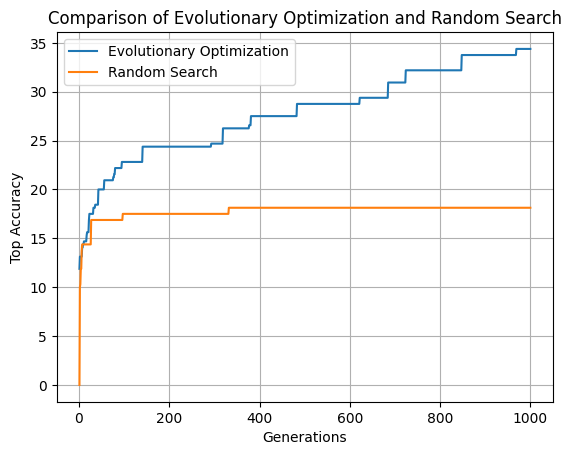

In [ ]:
# Plot the accuracies
plot_accuracies(evolutionary_accuracies, random_accuracies)

Epoch 1/1000: Highest Accuracy = 20.94%
Epoch 2/1000: Highest Accuracy = 20.94%
Epoch 3/1000: Highest Accuracy = 20.94%
Epoch 4/1000: Highest Accuracy = 21.25%
Epoch 5/1000: Highest Accuracy = 21.25%
Epoch 6/1000: Highest Accuracy = 21.25%
Epoch 7/1000: Highest Accuracy = 21.25%
Epoch 8/1000: Highest Accuracy = 21.25%
Epoch 9/1000: Highest Accuracy = 21.56%
Epoch 10/1000: Highest Accuracy = 21.56%
Epoch 11/1000: Highest Accuracy = 21.56%
Epoch 12/1000: Highest Accuracy = 21.56%
Epoch 13/1000: Highest Accuracy = 21.88%
Epoch 14/1000: Highest Accuracy = 21.88%
Epoch 15/1000: Highest Accuracy = 21.88%
Epoch 16/1000: Highest Accuracy = 21.88%
Epoch 17/1000: Highest Accuracy = 21.88%
Epoch 18/1000: Highest Accuracy = 21.88%
Epoch 19/1000: Highest Accuracy = 21.88%
Epoch 20/1000: Highest Accuracy = 21.88%
Epoch 21/1000: Highest Accuracy = 21.88%
Epoch 22/1000: Highest Accuracy = 21.88%
Epoch 23/1000: Highest Accuracy = 21.88%
Epoch 24/1000: Highest Accuracy = 21.88%
Epoch 25/1000: Highest Ac

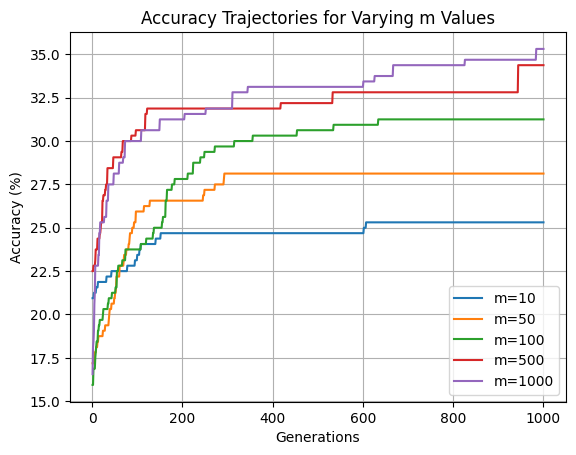

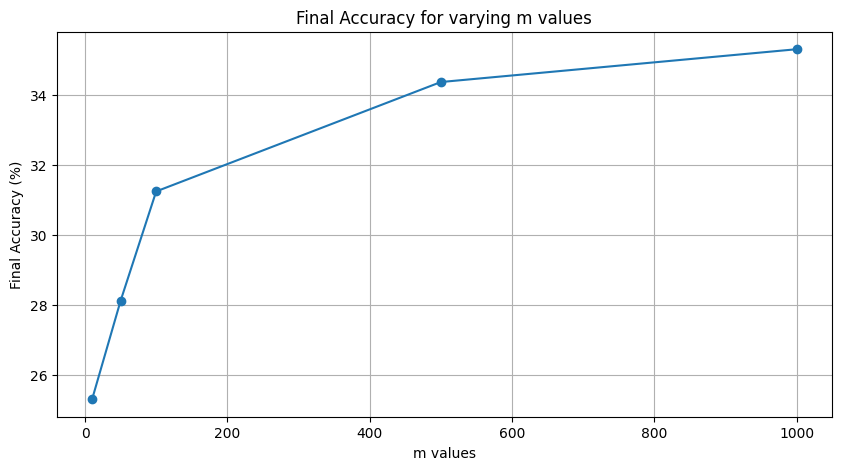

In [ ]:
import matplotlib.pyplot as plt

# Assuming the other functions and model initialization are defined elsewhere in your code

m_values = [10, 50, 100, 500, 1000]  # list of m values you want to test
final_accuracies = []

for m in m_values:
    top_accuracies = evolutionary_optimization(model, initial_weights, test_loader, criterion, num_epochs, num_subnets, subnet_size, n=5, m=m)
    final_accuracies.append(top_accuracies[-1])
    plt.plot(range(1, num_epochs + 1), top_accuracies, label=f'm={m}')

plt.xlabel('Generations')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Trajectories for Varying m Values')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(m_values, final_accuracies, marker='o')
plt.xlabel('m values')
plt.ylabel('Final Accuracy (%)')
plt.title('Final Accuracy for varying m values')
plt.grid(True)
plt.show()

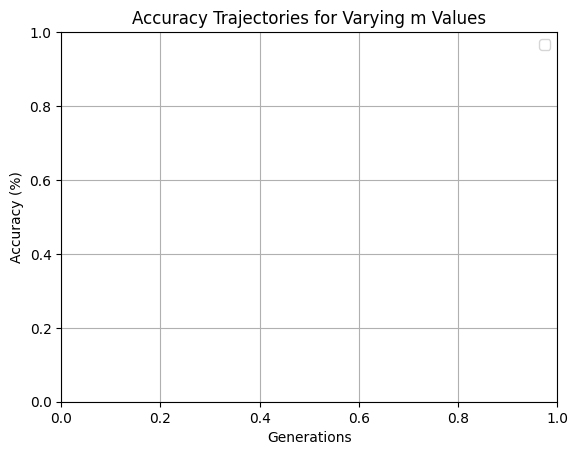

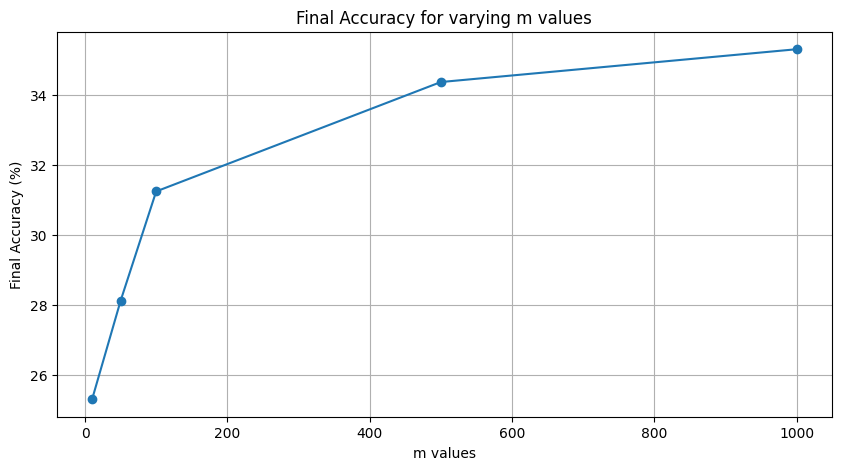

In [ ]:
plt.xlabel('Generations')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Trajectories for Varying m Values')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(m_values, final_accuracies, marker='o')
plt.xlabel('m values')
plt.ylabel('Final Accuracy (%)')
plt.title('Final Accuracy for varying m values')
plt.grid(True)
plt.show()